In [2]:
import numpy as np
import os
import random
import torch
from torch import nn
import torch.nn.functional as F
import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from vit import ViT
from torch.utils.data import Subset


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def select_two_classes_from_cifar10(dataset, classes):
    idx = (np.array(dataset.targets) == classes[0]) | (np.array(dataset.targets) == classes[1])
    dataset.targets = np.array(dataset.targets)[idx]
    dataset.targets[dataset.targets==classes[0]] = 0
    dataset.targets[dataset.targets==classes[1]] = 1
    dataset.targets= dataset.targets.tolist()  
    dataset.data = dataset.data[idx]
    return dataset

def prepare_dataloaders(batch_size, classes=[3, 7],small_sample=False):
    # TASK: Experiment with data augmentation
    train_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    test_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=test_transform)

    # select two classes 
    trainset = select_two_classes_from_cifar10(trainset, classes=classes)
    testset = select_two_classes_from_cifar10(testset, classes=classes)

    # reduce dataset size
    trainset, _ = torch.utils.data.random_split(trainset, [5000, 5000])
    testset, _ = torch.utils.data.random_split(testset, [1000, 1000])

    if(small_sample==True):
        trainset = Subset(trainset,range(512))
        testset = Subset(testset,range(128))
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True
    )
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False
    )
    return trainloader, testloader, trainset, testset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(f"Model will run on {device}")
set_seed(seed=1)


image_size=(32,32)
patch_size=(4,4) 
channels=3 
embed_dim=512
num_heads=1
num_layers=6 
num_classes=2
pos_enc='fixed' 
pool='cls' 
dropout=0.15
fc_dim=None 
num_epochs=60
batch_size=16 #16
lr=1e-4
warmup_steps=625
weight_decay=1e-4 
gradient_clipping=1
         


loss_function = nn.CrossEntropyLoss()

train_iter, test_iter, trainset, testset = prepare_dataloaders(batch_size=batch_size,small_sample=True)


model = ViT(image_size=image_size, patch_size=patch_size, channels=channels, 
            embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers,
            pos_enc=pos_enc, pool=pool, dropout=dropout, fc_dim=fc_dim, 
            num_classes=num_classes
)

if torch.cuda.is_available():
    model = model.to('cuda')

opt = torch.optim.AdamW(lr=lr, params=model.parameters(), weight_decay=weight_decay)
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / warmup_steps, 1.0))


# training loop
best_val_loss = 1e10
for e in range(num_epochs):
    print(f'\n epoch {e}')
    model.train()
    train_loss = 0
    for image, label in tqdm.tqdm(train_iter):
        if torch.cuda.is_available():
            image, label = image.to('cuda'), label.to('cuda')
        opt.zero_grad()
        out,_ = model(image)
        loss = loss_function(out, label)
        loss.backward()
        train_loss += loss.item()
        # if the total gradient vector has a length > 1, we clip it back down to 1.
        if gradient_clipping > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        opt.step()
        sch.step()

    train_loss/=len(train_iter)

    val_loss = 0
    with torch.no_grad():
        model.eval()
        tot, cor= 0.0, 0.0
        for image, label in test_iter:
            if torch.cuda.is_available():
                image, label = image.to('cuda'), label.to('cuda')
            out,_ = model(image)
            loss = loss_function(out, label)
            val_loss += loss.item()
            out = out.argmax(dim=1)
            tot += float(image.size(0))
            cor += float((label == out).sum().item())
        acc = cor / tot
        val_loss /= len(test_iter)
        print(f'-- train loss {train_loss:.3f} -- validation accuracy {acc:.3f} -- validation loss: {val_loss:.3f}')
        if val_loss <= best_val_loss:
            torch.save(model.state_dict(), 'model.pth')
            best_val_loss = val_loss




Model will run on cpu
Files already downloaded and verified
Files already downloaded and verified

 epoch 0


100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


-- train loss 0.796 -- validation accuracy 0.477 -- validation loss: 0.795

 epoch 1


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


-- train loss 0.784 -- validation accuracy 0.484 -- validation loss: 0.795

 epoch 2


100%|██████████| 32/32 [00:22<00:00,  1.42it/s]


-- train loss 0.774 -- validation accuracy 0.531 -- validation loss: 0.767

 epoch 3


100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


-- train loss 0.803 -- validation accuracy 0.531 -- validation loss: 0.770

 epoch 4


100%|██████████| 32/32 [00:25<00:00,  1.26it/s]


-- train loss 0.794 -- validation accuracy 0.461 -- validation loss: 0.821

 epoch 5


 50%|█████     | 16/32 [00:12<00:12,  1.24it/s]


KeyboardInterrupt: 

<h1>Plotting attention: </h1> 

status: when using hook, we loose the batch dimension which breaks the forward. Why do we loose the batch-dimension? 


<b>#todo tomorrow</b> because you only save a single variable in ViT. Need to save all tensors along batch-dim 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

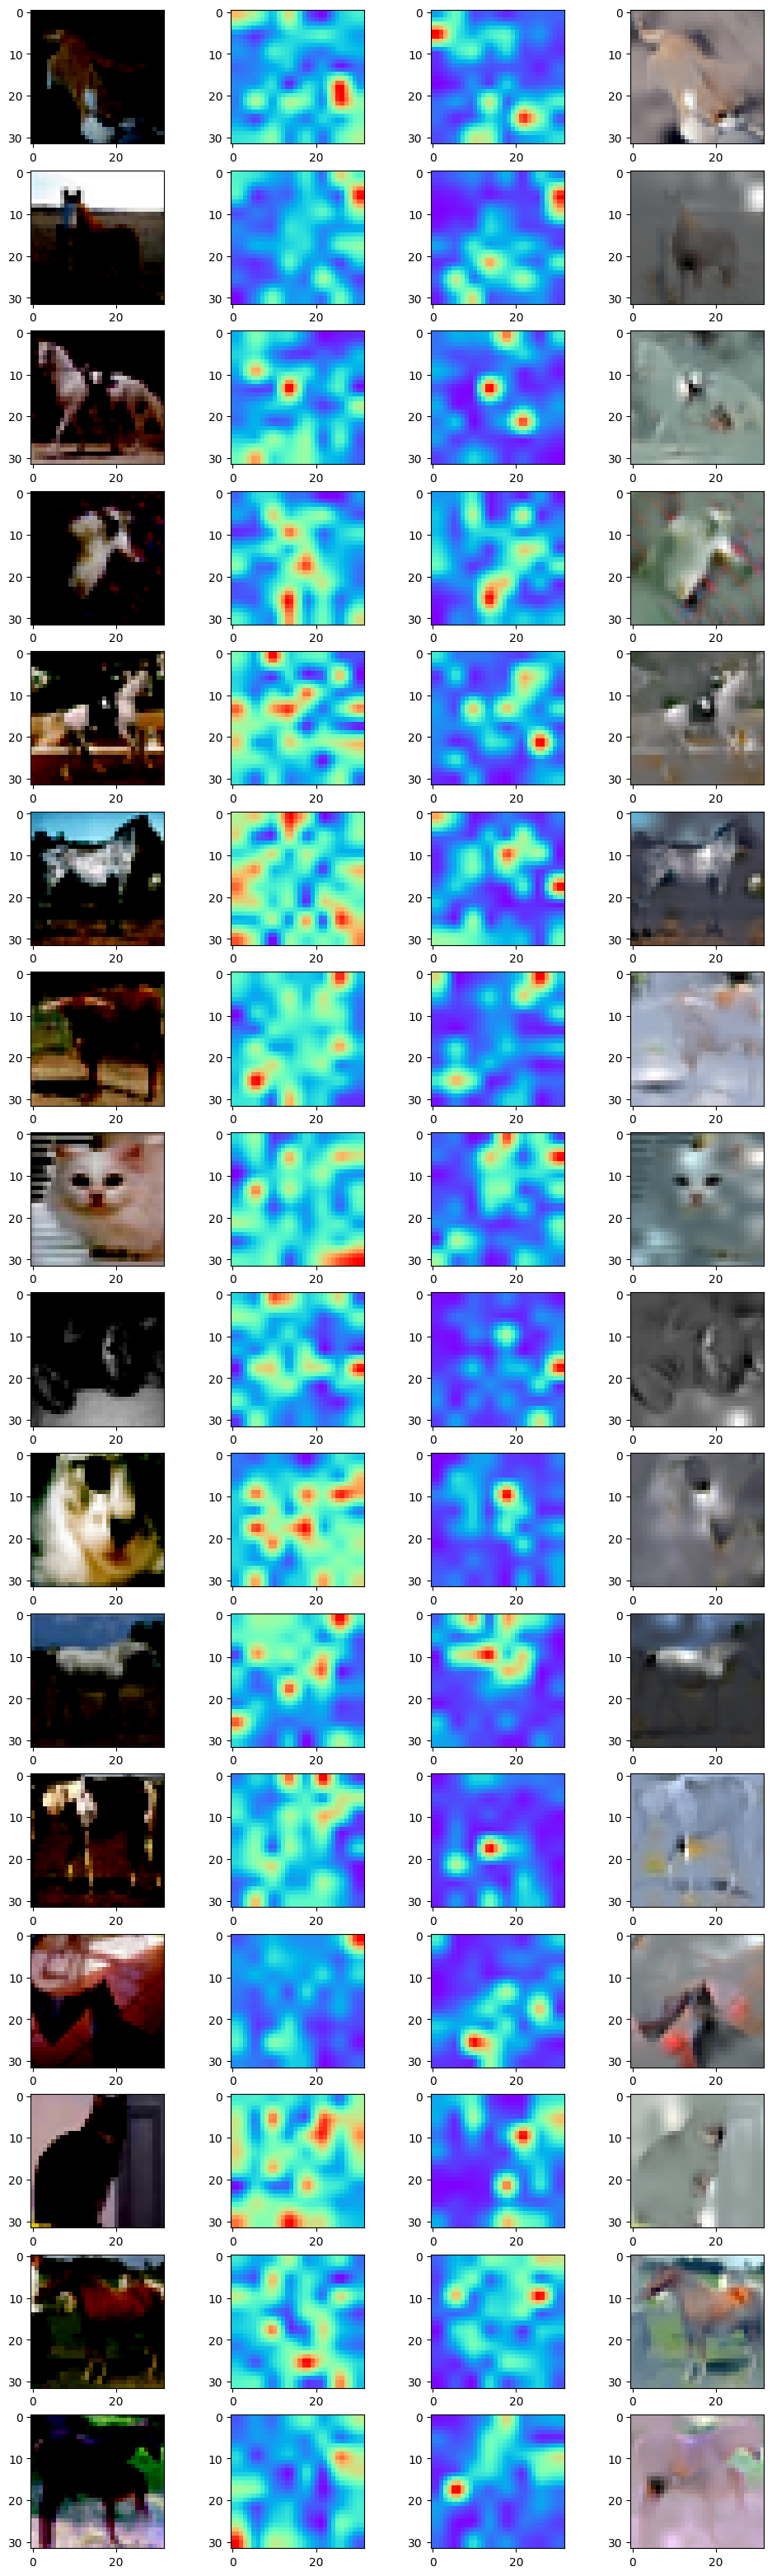

In [5]:
import matplotlib.pyplot as plt
def attention_rollout(attention_list, L):
    if L==0:
        return attention_list[L]
    else:
        tmp = torch.mul((attention_list[L]+torch.eye(attention_list[L].shape[0],attention_list[L].shape[1])),attention_rollout(attention_list, L-1))
        return tmp/torch.sum(tmp,dim=1) #need to row-normalize according to https://jacobgil.github.io/deeplearning/vision-transformer-explainability


H, W = image_size
patch_h, patch_w = patch_size
assert H % patch_h == 0 and W % patch_w == 0, 'Image dimensions must be divisible by the patch size'

num_patches = (H // patch_h) * (W // patch_w)
num_patches_h = (H // patch_h)
num_patches_w = (W // patch_w)
model.eval()
image,label = next(iter(train_iter))
prediction,attention_li = model.forward(image)
fig, ax = plt.subplots(image.shape[0],4,figsize=(12,40))
for i in range(image.shape[0]):
    im_t = image[i].permute(1,2,0)
    ax[i,0].imshow(im_t)
    attention_map = attention_li[-1][i,0,1:].reshape(num_patches_h,num_patches_w) #last layer attention
    map = torch.nn.functional.interpolate(input=attention_map.unsqueeze(0).unsqueeze(0),size=image_size,mode="bilinear")
    map = map.squeeze(0).squeeze(0)
    map = (map-torch.min(map))/(torch.max(map)-torch.min(map)) #rescale to [0,1]
    map = map.detach().cpu().numpy()
    ax[i,1].imshow(map,cmap="rainbow")
    single_image = [x[i,:,:] for x in attention_li]
    #print(len(single_image)-1)
    #print(type(single_image))
    attention_rollout_ = attention_rollout(single_image,len(single_image)-1)
    attention_rollout_ = attention_rollout_[0,1:].reshape(num_patches_h,num_patches_w)
    map = torch.nn.functional.interpolate(input=attention_rollout_.unsqueeze(0).unsqueeze(0),size=image_size,mode="bilinear")
    map = map.squeeze(0).squeeze(0)
    map = (map-torch.min(map))/(torch.max(map)-torch.min(map)) #rescale to [0,1]
    map = map.detach().cpu().numpy()
    image_mask = np.multiply(np.repeat(map[:,:,None],axis=-1,repeats=3),image[i].permute(1,2,0)) #element-wise multiplication - uneccessary but cool
    mins, _ = torch.min(image_mask.view(-1,3),dim=0)
    maxs, _ = torch.max(image_mask.view(-1,3),dim=0)
    image_mask = ((image_mask - mins)/(maxs-mins))
    ax[i,3].imshow(image_mask)
    #cm = plt.get_cmap('gist_rainbow')
    ax[i,2].imshow(map,cmap="rainbow",alpha=1.0)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[tensor([[0.0149, 0.0122, 0.0111,  ..., 0.0143, 0.0115, 0.0178],
        [0.0169, 0.0039, 0.0017,  ..., 0.0032, 0.0045, 0.0068],
        [0.0096, 0.0054, 0.0035,  ..., 0.0092, 0.0079, 0.0106],
        ...,
        [0.0059, 0.0186, 0.0259,  ..., 0.0101, 0.0080, 0.0179],
        [0.0135, 0.0088, 0.0048,  ..., 0.0029, 0.0034, 0.0031],
        [0.0125, 0.0152, 0.0143,  ..., 0.0235, 0.0131, 0.0325]],
       grad_fn=<SliceBackward0>), tensor([[0.0109, 0.0265, 0.0156,  ..., 0.0078, 0.0101, 0.0093],
        [0.0157, 0.0180, 0.0083,  ..., 0.0080, 0.0109, 0.0069],
        [0.0103, 0.0200, 0.0189,  ..., 0.0079, 0.0106, 0.0089],
        ...,
        [0.0129, 0.0184, 0.0106,  ..., 0.0143, 0.0128, 0.0196],
        [0.0106, 0.0192, 0.0145,  ..., 0.0102, 0.0124, 0.0174],
        [0.0197, 0.0201, 0.0183,  ..., 0.0129, 0.0127, 0.0104]],
       grad_fn=<SliceBackward0>), tensor([[0.0234, 0.0388, 0.0059,  ..., 0.0216, 0.0172, 0.0087],
        [0.0094, 0.0041, 0.0046,  ..., 0.0180, 0.0095, 0.0041],
       

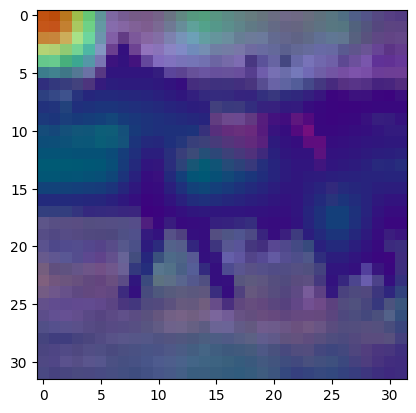

In [ ]:
# def attention_rollout(attention_list, L):
#     if L==0:
#         return attention_list[L]
#     else:
#         tmp = torch.mul((attention_list[L]+torch.eye(attention_list[L].shape[0],attention_list[L].shape[1])),attention_rollout(attention_list, L-1))
#         return tmp/torch.sum(tmp,dim=1) #need to row-normalize according to https://jacobgil.github.io/deeplearning/vision-transformer-explainability
         

# single_image = [x[0,:,:] for x in attention_li]
# print(single_image)
# attention_rollout = attention_rollout(single_image,len(single_image)-1)
# print(attention_rollout.shape)
# attention_rollout = attention_rollout[0,1:].reshape(num_patches_h,num_patches_w)
# map = torch.nn.functional.interpolate(input=attention_rollout.unsqueeze(0).unsqueeze(0),size=image_size,mode="bilinear")
# map = map.squeeze(0).squeeze(0)
# map = (map-torch.min(map))/(torch.max(map)-torch.min(map)) #rescale to [0,1]
# map = map.detach().cpu().numpy()
# image_mask = np.multiply(np.repeat(map[:,:,None],axis=-1,repeats=3),image[-1].permute(1,2,0))
# fig, ax = plt.subplots(1,1)
# ax.imshow(im_t)
# #cm = plt.get_cmap('gist_rainbow')
# ax.imshow(map,cmap="rainbow",alpha=0.5)

